# df105_WBosonAnalysis
The W boson mass analysis from the ATLAS Open Data release of 2020, with RDataFrame.

This tutorial is the analysis of the W boson mass taken from the ATLAS Open Data release in 2020
(http://opendata.atlas.cern/release/2020/documentation/). The data was recorded with the ATLAS detector
during 2016 at a center-of-mass energy of 13 TeV. W bosons are produced frequently at the LHC and
are an important background to studies of Standard Model processes, for example the Higgs boson analyses.

The analysis is translated to a RDataFrame workflow processing up to 60 GB of simulated events and data.
By default the analysis runs on a preskimmed dataset to reduce the runtime. The full dataset can be used with
the --full-dataset argument and you can also run only on a fraction of the original dataset using the argument --lumi-scale.

See the [corresponding spec json file](https://github.com/root-project/root/blob/master/tutorials/dataframe/df105_WBosonAnalysis.json).




**Author:** Stefan Wunsch (KIT, CERN)  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, April 17, 2024 at 11:08 AM.</small></i>

In [1]:
import ROOT
import sys
import json
import argparse
import os

Argument parsing

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--lumi-scale", type=float, default=0.001,
                    help="Run only on a fraction of the total available 10 fb^-1 (only usable together with --full-dataset)")
parser.add_argument("--full-dataset", action="store_true", default=False,
                    help="Use the full dataset (use --lumi-scale to run only on a fraction of it)")
parser.add_argument("-b", action="store_true", default=False, help="Use ROOT batch mode")
parser.add_argument("-t", action="store_true", default=False, help="Use implicit multi threading (for the full dataset only possible with --lumi-scale 1.0)")
if 'df105_WBosonAnalysis.py' in sys.argv[0]:
    # Script
    args = parser.parse_args()
else:
    # Notebook
    args = parser.parse_args(args=[])

if args.b: ROOT.gROOT.SetBatch(True)
if args.t: ROOT.EnableImplicitMT()

if not args.full_dataset: lumi_scale = 0.001 # The preskimmed dataset contains only 0.01 fb^-1
else: lumi_scale = args.lumi_scale
lumi = 10064.0
print('Run on data corresponding to {:.2f} fb^-1 ...'.format(lumi * lumi_scale / 1000.0))

if args.full_dataset: dataset_path = "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22"
else: dataset_path = "root://eospublic.cern.ch//eos/root-eos/reduced_atlas_opendata/w"

Run on data corresponding to 0.01 fb^-1 ...


Create a ROOT dataframe for each dataset
Note that we load the filenames from the external json file placed in the same folder than this script.

In [3]:
files = json.load(open(os.path.join(ROOT.gROOT.GetTutorialsDir(), "dataframe/df105_WBosonAnalysis.json")))
processes = files.keys()
df = {}
xsecs = {}
sumws = {}
samples = []
for p in processes:
    for d in files[p]:
        # Construct the dataframes
        folder = d[0] # Folder name
        sample = d[1] # Sample name
        xsecs[sample] = d[2] # Cross-section
        sumws[sample] = d[3] # Sum of weights
        num_events = d[4] # Number of events
        samples.append(sample)
        df[sample] = ROOT.RDataFrame("mini", "{}/1lep/{}/{}.1lep.root".format(dataset_path, folder, sample))

        # Scale down the datasets if requested
        if args.full_dataset and lumi_scale < 1.0:
            df[sample] = df[sample].Range(int(num_events * lumi_scale))

Plugin No such file or directory loading sec.protocol libXrdSeckrb5-5.so


Select events for the analysis

Just-in-time compile custom helper function performing complex computations

In [4]:
ROOT.gInterpreter.Declare("""
bool GoodElectronOrMuon(int type, float pt, float eta, float phi, float e, float trackd0pv, float tracksigd0pv, float z0)
{
    ROOT::Math::PtEtaPhiEVector p(pt / 1000.0, eta, phi, e / 1000.0);
    if (abs(z0 * sin(p.theta())) > 0.5) return false;
    if (type == 11 && abs(eta) < 2.46 && (abs(eta) < 1.37 || abs(eta) > 1.52)) {
        if (abs(trackd0pv / tracksigd0pv) > 5) return false;
        return true;
    }
    if (type == 13 && abs(eta) < 2.5) {
        if (abs(trackd0pv / tracksigd0pv) > 3) return false;
        return true;
    }
    return false;
}
""")

for s in samples:
    # Select events with a muon or electron trigger and with a missing transverse energy larger than 30 GeV
    df[s] = df[s].Filter("trigE || trigM")\
                 .Filter("met_et > 30000")

    # Find events with exactly one good lepton
    df[s] = df[s].Define("good_lep", "lep_isTightID && lep_pt > 35000 && lep_ptcone30 / lep_pt < 0.1 && lep_etcone20 / lep_pt < 0.1")\
                 .Filter("ROOT::VecOps::Sum(good_lep) == 1")

    # Apply additional cuts in case the lepton is an electron or muon
    df[s] = df[s].Define("idx", "ROOT::VecOps::ArgMax(good_lep)")\
                 .Filter("GoodElectronOrMuon(lep_type[idx], lep_pt[idx], lep_eta[idx], lep_phi[idx], lep_E[idx], lep_trackd0pvunbiased[idx], lep_tracksigd0pvunbiased[idx], lep_z0[idx])")

Apply luminosity, scale factors and MC weights for simulated events

In [5]:
for s in samples:
    if "data" in s:
        df[s] = df[s].Define("weight", "1.0")
    else:
        df[s] = df[s].Define("weight", "scaleFactor_ELE * scaleFactor_MUON * scaleFactor_LepTRIGGER * scaleFactor_PILEUP * mcWeight * {} / {} * {}".format(xsecs[s], sumws[s], lumi))

Compute transverse mass of the W boson using the lepton and the missing transverse energy and make a histogram

In [6]:
ROOT.gInterpreter.Declare("""
float ComputeTransverseMass(float met_et, float met_phi, float lep_pt, float lep_eta, float lep_phi, float lep_e)
{
    ROOT::Math::PtEtaPhiEVector met(met_et, 0, met_phi, met_et);
    ROOT::Math::PtEtaPhiEVector lep(lep_pt, lep_eta, lep_phi, lep_e);
    return (met + lep).Mt() / 1000.0;
}
""")

histos = {}
for s in samples:
    df[s] = df[s].Define("mt_w", "ComputeTransverseMass(met_et, met_phi, lep_pt[idx], lep_eta[idx], lep_phi[idx], lep_E[idx])")
    histos[s] = df[s].Histo1D(ROOT.RDF.TH1DModel(s, "mt_w", 24, 60, 180), "mt_w", "weight")

Run the event loop and merge histograms of the respective processes

RunGraphs allows to run the event loops of the separate RDataFrame graphs
concurrently. This results in an improved usage of the available resources
if each separate RDataFrame can not utilize all available resources, e.g.,
because not enough data is available.

In [7]:
ROOT.RDF.RunGraphs([histos[s] for s in samples])

def merge_histos(label):
    h = None
    for i, d in enumerate(files[label]):
        t = histos[d[1]].GetValue()
        if i == 0: h = t.Clone()
        else: h.Add(t)
    h.SetNameTitle(label, label)
    return h

data = merge_histos("data")
wjets = merge_histos("wjets")
zjets = merge_histos("zjets")
ttbar = merge_histos("ttbar")
diboson = merge_histos("diboson")
singletop = merge_histos("singletop")

Create the plot

Set styles

In [8]:
ROOT.gROOT.SetStyle("ATLAS")

Create canvas

In [9]:
c = ROOT.TCanvas("c", "", 600, 600)
c.SetTickx(0)
c.SetTicky(0)
c.SetLogy()

Draw stack with MC contributions

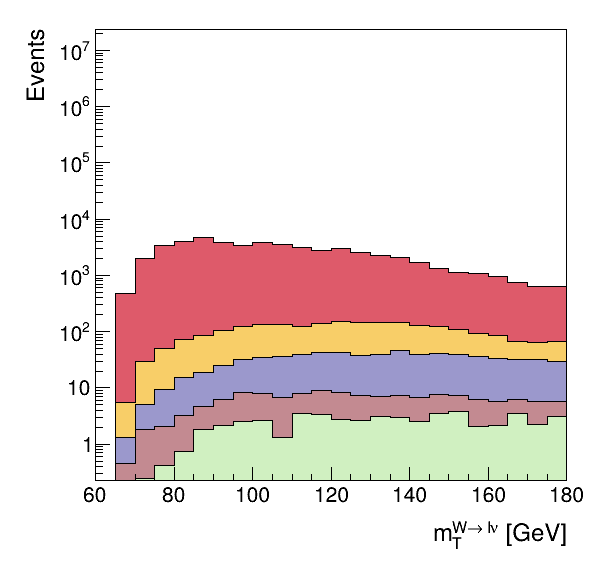

In [10]:
stack = ROOT.THStack()
for h, color in zip(
        [singletop, diboson, ttbar, zjets, wjets],
        [(208, 240, 193), (195, 138, 145), (155, 152, 204), (248, 206, 104), (222, 90, 106)]):
    h.SetLineWidth(1)
    h.SetLineColor(1)
    h.SetFillColor(ROOT.TColor.GetColor(*color))
    stack.Add(h)
stack.Draw("HIST")
stack.GetXaxis().SetLabelSize(0.04)
stack.GetXaxis().SetTitleSize(0.045)
stack.GetXaxis().SetTitleOffset(1.3)
stack.GetXaxis().SetTitle("m_{T}^{W#rightarrow l#nu} [GeV]")
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetLabelSize(0.04)
stack.GetYaxis().SetTitleSize(0.045)
stack.SetMaximum(1e10 * args.lumi_scale)
stack.SetMinimum(1)

Draw data

In [11]:
data.SetMarkerStyle(20)
data.SetMarkerSize(1.2)
data.SetLineWidth(2)
data.SetLineColor(ROOT.kBlack)
data.Draw("E SAME")

Add legend

In [12]:
legend = ROOT.TLegend(0.60, 0.65, 0.92, 0.92)
legend.SetTextFont(42)
legend.SetFillStyle(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.04)
legend.SetTextAlign(32)
legend.AddEntry(data, "Data" ,"lep")
legend.AddEntry(wjets, "W+jets", "f")
legend.AddEntry(zjets, "Z+jets", "f")
legend.AddEntry(ttbar, "t#bar{t}", "f")
legend.AddEntry(diboson, "Diboson", "f")
legend.AddEntry(singletop, "Single top", "f")
legend.Draw()

Add ATLAS label

In [13]:
text = ROOT.TLatex()
text.SetNDC()
text.SetTextFont(72)
text.SetTextSize(0.045)
text.DrawLatex(0.21, 0.86, "ATLAS")
text.SetTextFont(42)
text.DrawLatex(0.21 + 0.16, 0.86, "Open Data")
text.SetTextSize(0.04)
text.DrawLatex(0.21, 0.80, "#sqrt{{s}} = 13 TeV, {:.2f} fb^{{-1}}".format(lumi * args.lumi_scale / 1000.0))

Save the plot

In [14]:
c.SaveAs("df105_WBosonAnalysis.png")
print("Saved figure to df105_WBosonAnalysis.png")

Saved figure to df105_WBosonAnalysis.png


Info in <TCanvas::Print>: png file df105_WBosonAnalysis.png has been created


Draw all canvases 

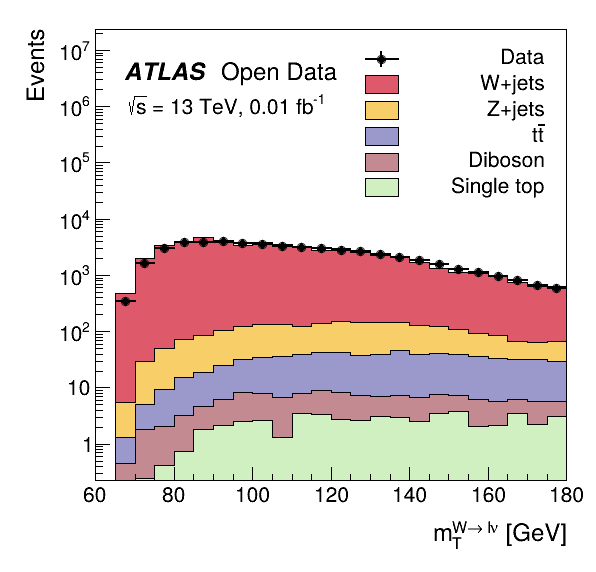

In [15]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()